# First simulation 

In this notebook, we run some experiments on dataset **NASA**.

In [1]:
import os
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from sksurv.metrics import brier_score
from time import time

import warnings
warnings.filterwarnings('ignore')

/Users/acsi/Working/Signature-survival/CoxSig/.venv_CoxSig36/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data loading & preprocessing

NASA description

***Selected longitudinal features***

***Number of individuals***

***Censoring level***

In [2]:
from data_loader import load_NASA
paths, surv_labels, ddh_info_sup = load_NASA.load()
paths = paths.clone()
n_samples, n_sampling_times, _ = paths.shape
sampling_times = paths[0, :, 0]
surv_times, surv_inds = surv_labels[:, 0], surv_labels[:, 1]

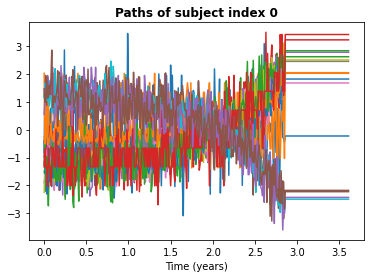

In [3]:
# plot time series of subject index 1
idx = 1
plt.plot(sampling_times, paths[idx,:,1:])
plt.xlabel("Time (years)")
plt.ylabel("")
plt.title("Paths of subject index 0", fontweight="bold", size=12)
plt.show()

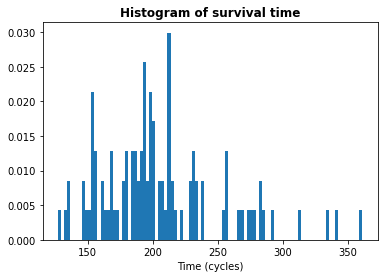

In [4]:
plt.hist(surv_times[surv_inds == 1] * 100, bins=100, density=True)
plt.xlabel("Time (cycles)")
plt.title("Histogram of survival time", fontweight="bold")
plt.show()

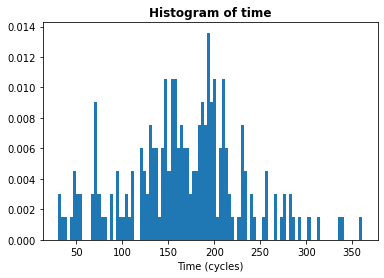

In [5]:
plt.hist(surv_times * 100, bins=100, density=True)
plt.xlabel("Time (cycles)")
plt.title("Histogram of time", fontweight="bold")
plt.show()

***Split train-test data***

In [6]:
train_test_share = .8
n_samples = paths.shape[0]
n_sampling_times = paths.shape[1]
n_train_samples = int(train_test_share * n_samples)
train_index = np.random.default_rng(0).choice(n_samples, n_train_samples, replace=False)
test_index = [i for i in np.arange(n_samples) if i not in train_index]

paths_train = paths[train_index, :, :]
surv_labels_train = surv_labels[train_index, :]

paths_test = paths[test_index, :, :]
surv_labels_test = surv_labels[test_index, :]

***Setup for prediction***

In [7]:
sampling_times = np.array(paths[0, :, 0])
tte = surv_labels[surv_labels[:, 1] == 1][:, 0]
quantile_pred_times = np.array([.1, .2, .4])
pred_times = np.quantile(np.array(tte), quantile_pred_times)
n_eval_times = 3
eval_times = []
for k in range(n_eval_times):
    eval_times.append(max(np.quantile(np.array(tte), quantile_pred_times + (k+1) * .05) - pred_times))
eval_times = np.array(eval_times)

### Neural Controlled Differential Equation (NCDE)

epoch: 0, objective: 1.9311900734901428
epoch: 1, objective: 1.8395798206329346
epoch: 2, objective: 1.8099880814552307
epoch: 3, objective: 1.778881549835205
epoch: 4, objective: 1.746816098690033
epoch: 5, objective: 1.7159690856933594
epoch: 6, objective: 1.6809596419334412
epoch: 7, objective: 1.6469962000846863
epoch: 8, objective: 1.615892231464386
epoch: 9, objective: 1.5783156752586365
epoch: 10, objective: 1.5411871075630188
epoch: 11, objective: 1.5057360529899597
epoch: 12, objective: 1.4672189950942993
epoch: 13, objective: 1.4266294240951538
epoch: 14, objective: 1.3827219009399414
epoch: 15, objective: 1.3408008813858032
epoch: 16, objective: 1.3048055171966553
epoch: 17, objective: 1.2704079747200012
epoch: 18, objective: 1.2332501411437988
epoch: 19, objective: 1.1953089237213135
epoch: 20, objective: 1.1592140197753906
epoch: 21, objective: 1.1218186020851135
epoch: 22, objective: 1.0816675424575806
epoch: 23, objective: 1.0383513569831848
epoch: 24, objective: 0.99180

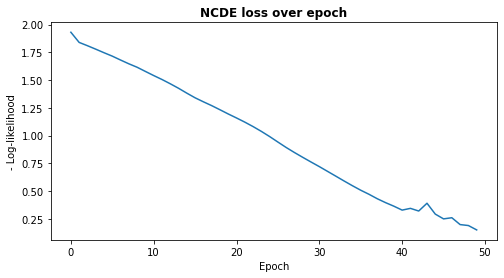

In [18]:
from src.cresnet import ControlledResNet

latent_dim = 4
hidden_dim = 128
path_dim = paths_train.shape[-1]
activation = 'tanh'
n_layers=2
learning_rate = 1e-4
batch_size = 64
num_epochs = 50
ncde = ControlledResNet(latent_dim, hidden_dim, path_dim, 
                        activation, n_layers, sampling_times)
ncde_optimizer = torch.optim.Adam(ncde.parameters(),
                                  lr=learning_rate)
start = time()
ncde.train(ncde_optimizer, paths_train, surv_labels_train, 
           batch_size, num_epochs, verbose=True)
ncde_bs = ncde.score(paths_test, surv_labels_test, pred_times, eval_times, "bs")
ncde_cindex = ncde.score(paths_test, surv_labels_test, pred_times, eval_times, 'c_index')
ncde_auc = ncde.score(paths_test, surv_labels_test, pred_times, eval_times, 'auc')
ncde_time = time() - start

### Cox Signature

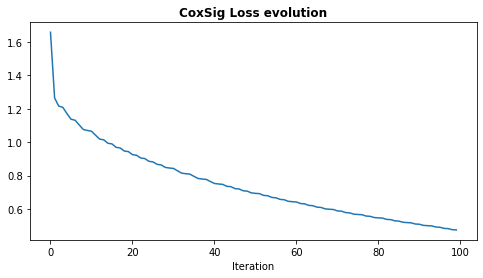

In [9]:
from src.coxsig import CoxSignature
# model with unnormalized features
start = time()
coxsig = CoxSignature(sig_level=2, alphas=1e-5, max_iter=100, plot_loss=True)
coxsig.train(paths_train, surv_labels_train)
coxsig_bs = coxsig.score(paths_test, surv_labels_test, pred_times, eval_times, "bs")
coxsig_cindex = coxsig.score(paths_test, surv_labels_test, pred_times, eval_times, 'c_index')
coxsig_auc = coxsig.score(paths_test, surv_labels_test, pred_times, eval_times, 'auc')
coxsig_time = time() - start

### Cox Signature Extension

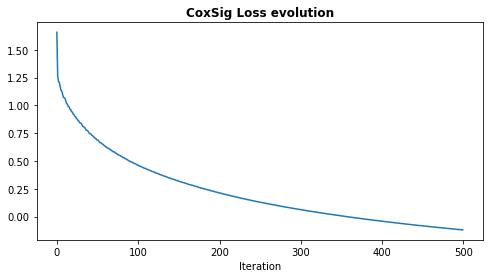

In [10]:
start = time()
coxsigext = CoxSignature(sig_level=2, alphas=1e-5, max_iter=500, plot_loss=True, ext_ver=True)
coxsigext.train(paths_train, surv_labels_train)
coxsigext_bs = coxsigext.score(paths_test, surv_labels_test, pred_times, eval_times, "bs")
coxsigext_cindex = coxsigext.score(paths_test, surv_labels_test, pred_times, eval_times, 'c_index')
coxsigext_auc = coxsigext.score(paths_test, surv_labels_test, pred_times, eval_times, 'auc')
coxsigext_time = time() - start

### Competing methods ###

### CoxFirst

In [11]:
from competing_methods.coxfirst import CoxFirst
start = time()
coxfirst = CoxFirst(alphas=np.array([1e-3]))
coxfirst.train(paths_train, surv_labels_train)
coxfirst_bs = coxfirst.score(paths_test, surv_labels_test, pred_times, eval_times, "bs")
coxfirst_cindex = coxfirst.score(paths_test, surv_labels_test, pred_times, eval_times, 'c_index')
coxfirst_auc = coxfirst.score(paths_test, surv_labels_test, pred_times, eval_times, 'auc')
coxfirst_time = time() - start

***RSF***

In [12]:
from competing_methods.rsf import RSF
start = time()
rsf = RSF()
rsf.train(paths_train, surv_labels_train)
rsf_bs = rsf.score(paths_test, surv_labels_test, pred_times, eval_times, "bs")
rsf_cindex = rsf.score(paths_test, surv_labels_test, pred_times, eval_times, 'c_index')
rsf_auc = rsf.score(paths_test, surv_labels_test, pred_times, eval_times, 'auc')
rsf_time = time() - start

### Dynamic-DeepHit

In [13]:
from competing_methods.dynamic_deephit_ext import construct_df, Dynamic_DeepHit_ext
from src.utils import score

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




INFO:tensorflow:Scale of 0 disables regularizer.


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.

Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead o

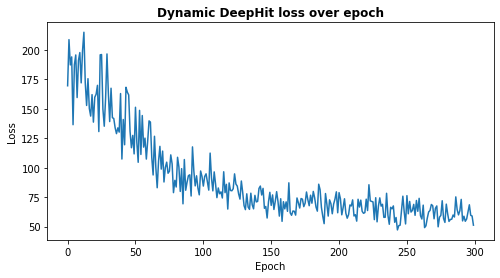

In [14]:
start = time()
# set-up for Dynamic DeepHit
cont_feat, bin_feat, time_scale, bin_df = ddh_info_sup
df = construct_df(paths.clone(), surv_labels, cont_feat, bin_feat, time_scale, bin_df)
dynamic_deephit = Dynamic_DeepHit_ext()
(data, time_, label), (mask1, mask2, mask3), (data_mi) = dynamic_deephit.preprocess(df, cont_feat)

# split data
tr_data, te_data = data[train_index, :, :], data[test_index, :, :]
tr_data_mi, te_data_mi = data_mi[train_index, :, :], data_mi[test_index, :, :]
tr_time,te_time = time_[train_index, :], time_[test_index, :]
tr_label,te_label = label[train_index, :], label[test_index, :]
tr_mask1,te_mask1 = mask1[train_index, :, :], mask1[test_index, :, :]
tr_mask2,te_mask2 = mask2[train_index, :, :], mask2[test_index, :, :]
tr_mask3,te_mask3 = mask3[train_index, :], mask3[test_index, :]

tr_data_full = (tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)

# train
dynamic_deephit.train(tr_data_full, sess_path=".", is_trained=False)

# predict
pred_time_scale = (pred_times * time_scale).astype(int)
eval_time_scale = (eval_times * time_scale).astype(int)
ddh_surv_preds = dynamic_deephit.predict(te_data, te_data_mi, 
                                         pred_time_scale, eval_time_scale)

n_pred_times = len(pred_times)
n_eval_times = len(eval_times)
ddh_bs = np.zeros((n_pred_times, n_eval_times))
ddh_cindex = np.zeros((n_pred_times, n_eval_times))
ddh_auc = np.zeros((n_pred_times, n_eval_times))
for j in np.arange(n_pred_times):
    pred_time = pred_times[j]
    
    # remove individuals whose survival time less than prediction time
    surv_times_test = surv_labels_test[:, 0]
    surv_inds_test = surv_labels_test[:, 1]
    idx_sel = surv_times_test >= pred_time
    surv_times_ = surv_times_test[idx_sel] - pred_time
    surv_inds_ = surv_inds_test[idx_sel]
    surv_labels_ = np.array([surv_times_, surv_inds_]).T
    surv_preds_ = ddh_surv_preds[:, j][idx_sel]

    ddh_bs[j] = score("bs", surv_labels_, surv_labels_, 
                      surv_preds_, eval_times)
    ddh_cindex[j] = score("c_index", surv_labels_, surv_labels_, 
                          surv_preds_, eval_times)
    ddh_auc[j] = score("auc", surv_labels_, surv_labels_, 
                          surv_preds_, eval_times)

ddh_time = time() - start

***Performace evaluation***

***C_index***

In [19]:
import prettytable
from prettytable import PrettyTable
cindex_table = PrettyTable()
cindex_table.field_names = ["p_t", "Model"] + ["d_t = "+str(t.round(3)) for t in eval_times]
for i in range(len(pred_times)):
    t = round(pred_times[i], 3)
    cindex_table.add_row(["", "NCDE"] + ncde_cindex[i].round(3).tolist())
    cindex_table.add_row(["", "CoxSig"] + coxsig_cindex[i].round(3).tolist())
    cindex_table.add_row([t, "CoxSigExt"] + coxsigext_cindex[i].round(3).tolist())
    cindex_table.add_row(["", "CoxFirst"] + coxfirst_cindex[i].round(3).tolist())
    cindex_table.add_row(["", "Dyn_DeepHit"] + ddh_cindex[i].round(3).tolist())
    cindex_table.add_row([""]*5)
print(cindex_table)

+-------+-------------+-------------+-------------+-------------+
|  p_t  |    Model    | d_t = 0.094 | d_t = 0.162 | d_t = 0.221 |
+-------+-------------+-------------+-------------+-------------+
|       |     NCDE    |    0.769    |    0.632    |    0.546    |
|       |    CoxSig   |    0.981    |    0.987    |    0.798    |
| 1.539 |  CoxSigExt  |    0.923    |    0.947    |    0.773    |
|       |   CoxFirst  |    0.654    |    0.461    |    0.479    |
|       | Dyn_DeepHit |    0.769    |    0.724    |    0.697    |
|       |             |             |             |             |
|       |     NCDE    |    0.372    |    0.372    |    0.508    |
|       |    CoxSig   |    0.837    |    0.837    |    0.803    |
| 1.666 |  CoxSigExt  |    0.674    |    0.674    |    0.738    |
|       |   CoxFirst  |    0.512    |    0.512    |    0.607    |
|       | Dyn_DeepHit |    0.698    |    0.977    |    0.967    |
|       |             |             |             |             |
|       | 

***Brier-score***

In [20]:
import prettytable
from prettytable import PrettyTable
bs_table = PrettyTable()
bs_table.field_names = ["p_t", "Model"] + ["d_t = "+str(t.round(3)) for t in eval_times]
for i in range(len(pred_times)):
    t = round(pred_times[i], 3)
    bs_table.add_row(["", "NCDE"] + ncde_bs[i].round(3).tolist())
    bs_table.add_row(["", "CoxSig"] + coxsig_bs[i].round(3).tolist())
    bs_table.add_row([t, "CoxSigExt"] + coxsigext_bs[i].round(3).tolist())
    bs_table.add_row(["", "CoxFirst"] + coxfirst_bs[i].round(3).tolist())
    bs_table.add_row(["", "Dyn_DeepHit"] + ddh_bs[i].round(3).tolist())
    bs_table.add_row([""]*5)
print(bs_table)

+-------+-------------+-------------+-------------+-------------+
|  p_t  |    Model    | d_t = 0.094 | d_t = 0.162 | d_t = 0.221 |
+-------+-------------+-------------+-------------+-------------+
|       |     NCDE    |    0.066    |    0.094    |    0.147    |
|       |    CoxSig   |     0.04    |    0.038    |    0.091    |
| 1.539 |  CoxSigExt  |    0.038    |     0.04    |    0.094    |
|       |   CoxFirst  |    0.058    |    0.089    |    0.143    |
|       | Dyn_DeepHit |    0.067    |    0.096    |    0.152    |
|       |             |             |             |             |
|       |     NCDE    |     0.08    |     0.08    |    0.112    |
|       |    CoxSig   |    0.061    |    0.068    |    0.096    |
| 1.666 |  CoxSigExt  |     0.05    |    0.054    |    0.085    |
|       |   CoxFirst  |    0.083    |    0.082    |    0.128    |
|       | Dyn_DeepHit |    0.082    |    0.079    |     0.11    |
|       |             |             |             |             |
|       | 

***AUC***

In [21]:
import prettytable
from prettytable import PrettyTable
auc_table = PrettyTable()
auc_table.field_names = ["p_t", "Model"] + ["d_t = "+str(t.round(3)) for t in eval_times]
for i in range(len(pred_times)):
    t = round(pred_times[i], 3)
    auc_table.add_row(["", "NCDE"] + ncde_auc[i].round(3).tolist())
    auc_table.add_row(["", "CoxSig"] + coxsig_auc[i].round(3).tolist())
    auc_table.add_row([t, "CoxSigExt"] + coxsigext_auc[i].round(3).tolist())
    auc_table.add_row(["", "CoxFirst"] + coxfirst_auc[i].round(3).tolist())
    auc_table.add_row(["", "Dyn_DeepHit"] + ddh_auc[i].round(3).tolist())
    auc_table.add_row([""]*5)
print(auc_table)

+-------+-------------+-------------+-------------+-------------+
|  p_t  |    Model    | d_t = 0.094 | d_t = 0.162 | d_t = 0.221 |
+-------+-------------+-------------+-------------+-------------+
|       |     NCDE    |    0.759    |    0.607    |     0.51    |
|       |    CoxSig   |     0.98    |     1.0     |    0.774    |
| 1.539 |  CoxSigExt  |    0.918    |    0.956    |    0.755    |
|       |   CoxFirst  |    0.686    |    0.451    |    0.478    |
|       | Dyn_DeepHit |    0.783    |    0.724    |    0.737    |
|       |             |             |             |             |
|       |     NCDE    |    0.381    |    0.381    |    0.565    |
|       |    CoxSig   |    0.833    |    0.833    |    0.812    |
| 1.666 |  CoxSigExt  |    0.667    |    0.667    |    0.764    |
|       |   CoxFirst  |     0.5     |     0.5     |    0.637    |
|       | Dyn_DeepHit |     0.69    |    0.976    |     0.96    |
|       |             |             |             |             |
|       | 